In [47]:
import agama
import pynbody
import pynbody.plot.sph as sph

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
filepath = "/Volumes/My Passport for Mac/TideB_4liz/GLX.01000"
s = pynbody.load(filepath)
s.physical_units()

In [3]:
g_mas = np.array(s.g["mass"])
g_pos = np.array(s.g["pos"])

s_mas = np.array(s.s["mass"])
s_pos = np.array(s.s["pos"])

d_mas = np.array(s.dm["mass"])
d_pos = np.array(s.dm["pos"])

In [4]:
b_mas = np.concatenate((g_mas, s_mas))
b_pos = np.concatenate((g_pos, s_pos))

In [5]:
units = {"length": 1, "velocity": 1, "mass": 1}
agama.setUnits(**units)

In [6]:
pot_nbody_dark = agama.Potential(type = "Multipole", particles = (d_pos, d_mas), symmetry = "axisymmetric", lmax = 2, mmax = 0, gridSizeR = 20)
pot_nbody_bary = agama.Potential(type = "CylSpline", particles = (b_pos, b_mas), symmetry = "axisymmetric", mmax = 0, gridSizeR = 20, gridSizeZ = 20)

pot_nbody = agama.Potential(pot_nbody_dark, pot_nbody_bary)  # combine components into single potential

print(pot_nbody)

CompositePotential{ Multipole, CylSpline } (symmetry: Axisymmetric)


In [7]:
gridR = agama.nonuniformGrid(500, 0.01, 100)
gridz = agama.symmetricGrid(500, 0.01, 100)
grid2R, grid2z = np.meshgrid(gridR, gridz)
gridRz = np.column_stack((grid2R.reshape(-1), grid2z.reshape(-1)))
gridx0z = np.column_stack((grid2R.reshape(-1), grid2R.reshape(-1) * 0, grid2z.reshape(-1)))
gridR00 = np.column_stack((gridR, gridR * 0, gridR * 0))
grid00z = np.column_stack((gridz * 0, gridz * 0, gridz))

<>:11: SyntaxWarning: invalid escape sequence '\;'
<>:12: SyntaxWarning: invalid escape sequence '\;'
<>:11: SyntaxWarning: invalid escape sequence '\;'
<>:12: SyntaxWarning: invalid escape sequence '\;'
/var/folders/nb/byfjq48d6jz8b3g74s3zr7rh0000gp/T/ipykernel_64253/1527347031.py:11: SyntaxWarning: invalid escape sequence '\;'
  plt.xlabel("$x \;{\\rm [kpc]}$", fontsize=15)
/var/folders/nb/byfjq48d6jz8b3g74s3zr7rh0000gp/T/ipykernel_64253/1527347031.py:12: SyntaxWarning: invalid escape sequence '\;'
  plt.ylabel("$y \;{\\rm [kpc]}$", fontsize=15)


plotting DM


<Figure size 640x480 with 0 Axes>

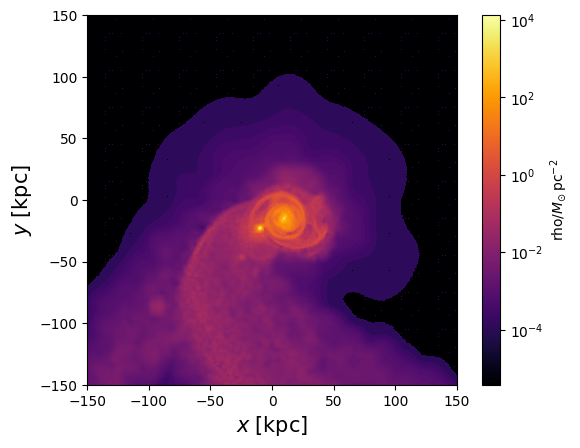

In [45]:
# -- Face-on DM density plot
print("plotting DM")
vmin = 5e1
vmax = 1e4
plt.clf()
figD = plt.figure(3)
axD = figD.add_subplot(1, 1, 1)
im_D = sph.image(
    s.s, qty="rho", width="300 kpc", cmap="inferno", units="Msol pc^-2", show_cbar=True, subplot=axD
)  # proj
plt.xlabel("$x \;{\\rm [kpc]}$", fontsize=15)
plt.ylabel("$y \;{\\rm [kpc]}$", fontsize=15)
plt.show()

Text(0, 0.5, '$\\phi(z)$ $[10^{4}$ $kpc$ $kms^{-1}]$')

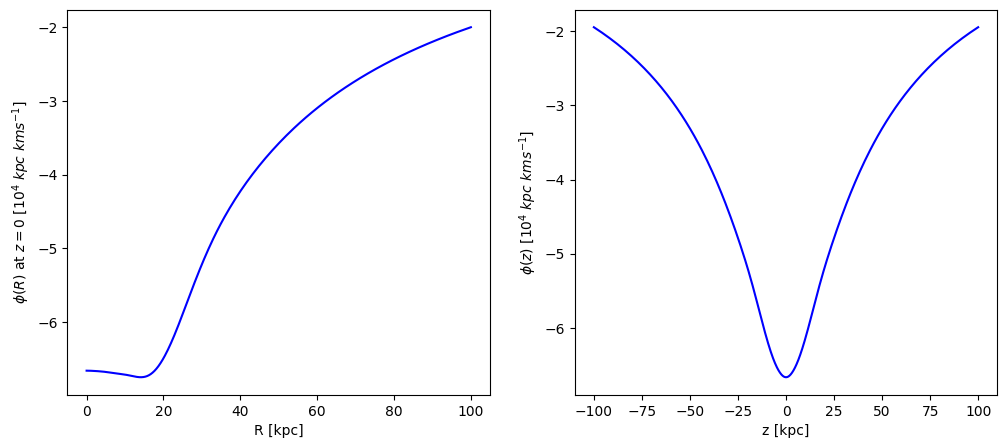

In [29]:
ax = plt.subplots(1, 2, figsize=(12, 5))[1]

ax[0].plot(gridR, pot_nbody.potential(gridR00) * 10 ** -4, label="Agama", color="blue")
ax[0].set_xlabel("R [kpc]")
ax[0].set_ylabel(r"$\phi(R)$ at $z=0$ $[10^{4}$ $kpc$ $kms^{-1}]$")

ax[1].plot(gridz, pot_nbody.potential(grid00z) * 10 ** -4, label="Agama", color="blue")
ax[1].set_xlabel("z [kpc]")
ax[1].set_ylabel(r"$\phi(z)$ $[10^{4}$ $kpc$ $kms^{-1}]$")

Text(0, 0.5, '$\\rho(z)$ $[M_\\odot/\\mathsf{kpc}^3]$')

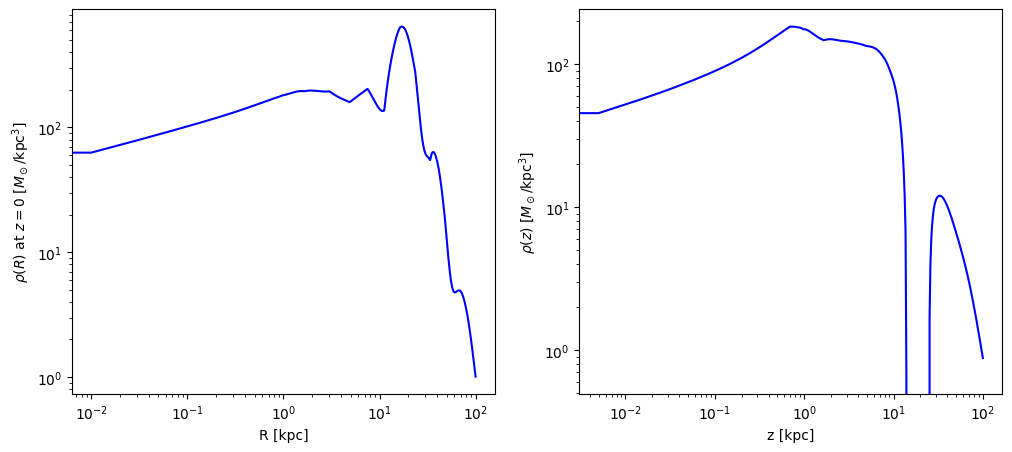

In [32]:
ax = plt.subplots(1, 2, figsize=(12, 5))[1]

ax[0].loglog(gridR, pot_nbody.density(gridR00) * 10 ** -4, label="Agama", color="blue")
ax[0].set_xlabel("R [kpc]")
ax[0].set_ylabel(r"$\rho(R)$ at $z=0$ $[M_\odot/\mathsf{kpc}^3]$")

ax[1].loglog(gridz, pot_nbody.density(grid00z) * 10 ** -4, label="Agama", color="blue")
ax[1].set_xlabel("z [kpc]")
ax[1].set_ylabel(r"$\rho(z)$ $[M_\odot/\mathsf{kpc}^3]$")

In [57]:
def get_actions(s, pot_nbody):

    af = agama.ActionFinder(pot_nbody, interp=False)

    idx_lst = []
    jr_lst = []
    jz_lst =[]
    jphi_lst = []

    idx = 0
    for star_pos, star_vel in zip(s.s["pos"], s.s["vel"]):
        init_cond = np.concatenate((np.array(star_pos), np.array(star_vel)))
        jr, jz, jphi = af(init_cond)

        idx_lst.append(idx)
        jr_lst.append(jr)
        jz_lst.append(jz)
        jphi_lst.append(jphi)

        idx += 1

    action_dict = {'star_idx': idx_lst, 'jr': jr_lst, 'jz': jz_lst, 'jphi': jphi_lst} 
    df = pd.DataFrame(action_dict)

    df.to_csv("actions_4liz.csv", index=False)

    return df


In [41]:
idx = 0

init_cond = np.concatenate((np.array(s.s["pos"][idx]), np.array(s.s["vel"][idx])))

get_actions(init_cond, pot_nbody)

(867.7008073728446, 11.0999852735201, -255.9200698316814)

In [58]:
df = get_actions(s, pot_nbody)

In [61]:
df.to_csv("actions_4liz.txt", index=False)